# Многомерная модель на LSTM

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Библиотека [`pandas_datareader`](https://pandas-datareader.readthedocs.io/en/latest/index.html "pandas-datareader &mdash; pandas-datareader documentation") для загрузки рыночных данных из различных источников в формате **pandas**:

In [3]:
from pandas_datareader import data as pdr

[Python wrapper](https://github.com/mrjbq7/ta-lib "mrjbq7/ta-lib: Python wrapper for TA-Lib (http://ta-lib.org/).") для библиотеки технического анализа [`TA-Lib`](http://ta-lib.org "TA-Lib : Technical Analysis Library") (индикаторы и т.п.):

In [4]:
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib
# pip install TA_Lib‑0.4.17‑cp37‑cp37m‑win_amd64.whl
# pip install TA-Lib

import talib

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
import tensorflow as tf
# tf.test.is_gpu_available()
tf.__version__

'2.0.0'

На днях официально вышел релиз [`tensorflow 2.0`](https://www.tensorflow.org/guide/effective_tf2 "Effective TensorFlow 2 &nbsp;|&nbsp; TensorFlow Core") (стал доступен в [Anaconda](https://anaconda.org/anaconda/tensorflow-gpu "Tensorflow Gpu :: Anaconda Cloud")). Там [`keras`](https://www.tensorflow.org/guide/keras "Keras &nbsp;|&nbsp; TensorFlow Core") теперь немного по другому импортируется.

In [7]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, ReLU, LeakyReLU, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Nadam

Моя маленькая библиотека для хранения рыночных данных, индикаторов и работы со скользящими окнами временных рядов:

In [8]:
from mdp.MarketData import MarketData
from mdp.MovingWindowFeatures import MovingWindowFeatures
from mdp.DataSetGenerator import DataSetGenerator
from mdp import Utils

In [9]:
# поскольку работа над классами идёт параллельно, то приходится иногда перезагружать модули
import importlib

import mdp
importlib.reload(mdp.MarketData)
importlib.reload(mdp.MovingWindowFeatures)
importlib.reload(mdp.DataSetGenerator)
importlib.reload(mdp.Utils);

## *Исходные данные*

Открытые рыночные данные будем загружать через [`pandas_datareader`](https://pandas-datareader.readthedocs.io/en/latest/index.html "pandas-datareader &mdash; pandas-datareader documentation"). В качестве источника данных мне понравился сервис [Tiingo](https://www.tiingo.com "Stock Market Tools | Tiingo"). В частности, его удобство в том, что он сразу выдаёт скорректированные (corporate actions adjusted) значения для всей "свечи" (четвёрки цен), а не только для цены закрытия.

In [10]:
msft_df = pdr.get_data_tiingo('MSFT', api_key=os.environ.get('TIINGO_API_KEY'), start=2010)

msft_df

close    high     low    open    volume  \
symbol date                                                                   
MSFT   2010-01-04 00:00:00+00:00   30.950   31.10   30.59   30.62  38409100   
       2010-01-05 00:00:00+00:00   30.960   31.10   30.64   30.85  49749600   
       2010-01-06 00:00:00+00:00   30.770   31.08   30.52   30.88  58182400   
       2010-01-07 00:00:00+00:00   30.452   30.70   30.19   30.63  50559700   
       2010-01-08 00:00:00+00:00   30.660   30.88   30.24   30.28  51197400   
...                                   ...     ...     ...     ...       ...   
       2019-10-23 00:00:00+00:00  137.240  137.45  135.61  136.88  31380309   
       2019-10-24 00:00:00+00:00  139.940  140.42  138.67  139.39  37278399   
       2019-10-25 00:00:00+00:00  140.730  141.14  139.20  139.34  25959724   
       2019-10-28 00:00:00+00:00  144.190  145.67  143.51  144.40  34912902   
       2019-10-29 00:00:00+00:00  142.830  144.50  142.65  144.08  20589469   

                                    adjClose     adjHigh      adjLow  \
symbol date                                                            
MSFT   2010-01-04 00:00:00+00:00   24.445510   24.563986   24.161168   
       2010-01-05 00:00:00+00:00   24.453408   24.563986   24.200660   
       2010-01-06 00:00:00+00:00   24.303339   24.548189   24.105879   
       2010-01-07 00:00:00+00:00   24.052170   24.248050   23.845232   
       2010-01-08 00:00:00+00:00   24.216457   24.390221   23.884724   
...                                      ...         ...         ...   
       2019-10-23 00:00:00+00:00  137.240000  137.450000  135.610000   
       2019-10-24 00:00:00+00:00  139.940000  140.420000  138.670000   
       2019-10-25 00:00:00+00:00  140.730000  141.140000  139.200000   
       2019-10-28 00:00:00+00:00  144.190000  145.670000  143.510000   
       2019-10-29 00:00:00+00:00  142.830000  144.500000  142.650000   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
MSFT   2010-01-04 00:00:00+00:00   24.184863   38409100      0.0          1.0  
       2010-01-05 00:00:00+00:00   24.366526   49749600      0.0          1.0  
       2010-01-06 00:00:00+00:00   24.390221   58182400      0.0          1.0  
       2010-01-07 00:00:00+00:00   24.192761   50559700      0.0          1.0  
       2010-01-08 00:00:00+00:00   23.916318   51197400      0.0          1.0  
...                                      ...        ...      ...          ...  
       2019-10-23 00:00:00+00:00  136.880000   31380309      0.0          1.0  
       2019-10-24 00:00:00+00:00  139.390000   37278399      0.0          1.0  
       2019-10-25 00:00:00+00:00  139.340000   25959724      0.0          1.0  
       2019-10-28 00:00:00+00:00  144.400000   34912902      0.0          1.0  
       2019-10-29 00:00:00+00:00  144.080000   20589469      0.0          1.0  

[2473 rows x 12 columns]

### Загрузка данных и вычисление индикаторов

Здесь открытый вопрос, какой длины историю разумно брать.
Для дневных цен, возможно, брать слишком длинную историю смысла нет, потому что торговые паттерны в прошлом, предположительно, отличаются от более современных. В то же время, если бы у нас были доступны, допустим, поминутные данные, то, возможно, в этом случае имело бы смысл брать как можно более длинную историю. Но тут ещё, конечно, следует учитывать вычислительную сложность и скорость обучения (всё-таки это учебная задача).

In [11]:
msft = MarketData.create_from_tiingo('MSFT', start='2014-01-01')

### Целевая переменная
В качестве целевой переменной будет использоваться не сама цена закрытия, а логарифмическая доходность, которая вычисляется как натуральный логарифм отношения текущей цены к цене предыдущего дня: $\text{Return} = \ln\bigl(\frac{\text{Price}{}_t}{\text{Price}_{t-1}}\bigr)$.

Как уже стало ясно, мы здесь попробуем построить многомерную модель. То есть будем пытаться прогнозировать значение временно́го ряда не только на основе предыдущих значений этого же ряда, но также и других, связанных с ним рядов: другие цены (доходности), объем торгов, технические индикаторы. То есть исходим из предположения, что эти признаки также позволяют прогнозировать целевую цену (по крайней мере, сторонники технического анализа считают именно так).

Ниже выведен список временны́х рядов, которые получены из исходных данных (дневных цен) и будут использоваться для создания признаков обучающей выборки: логарифмические доходности, объём торгов (volume) и различные технические индикаторы.

In [12]:
msft.src_feature_accessors

['get_o_logret',
 'get_h_logret',
 'get_l_logret',
 'get_c_logret',
 'get_v',
 'get_ema14',
 'get_ema30',
 'get_macd_fast12',
 'get_macd_slow26',
 'get_macd_signal9',
 'get_rsi14',
 'get_bband20_upper',
 'get_bband20_middle',
 'get_bband20_lowerband',
 'get_willr14']

### Стандартизация?

Ещё отдельный и неоднозначный вопрос - это стандартизация данных. Очевидно, *$Z$-score normalization* к нестационарному временно́му ряду целиком применять бессмысленно. В то же время какую-то стандартизацию, наверное, сделать желательно, потому что не все ряды одинакового масштаба (например, доходности, очевидно, отличаются от индикаторов, которые, в свою очередь отличаются от объёмов).

В то время как сами цены нестационарны (присутствует очевидный тренд), но, как показано ниже, переход к логарифмическим доходностям позволил сделать соответствующие ряды стационарными.

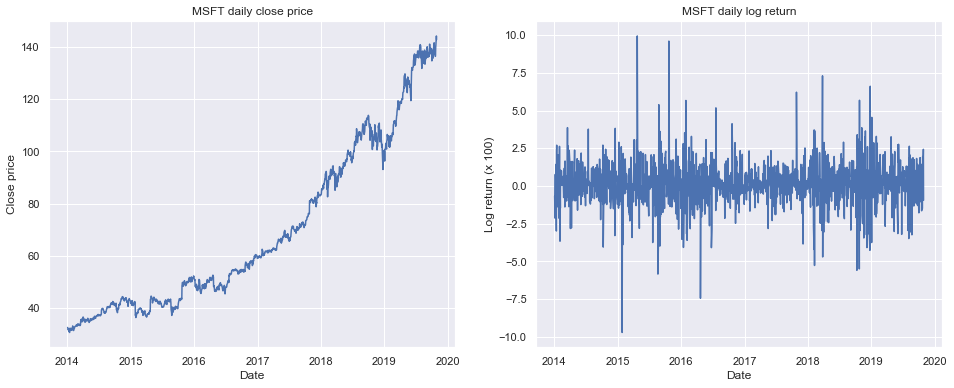

In [13]:
def plot_close_price_returns(market_data):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    def plot_ax(ax, title, x, xlabel, y, ylabel):
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)        
        ax.tick_params(axis='x', rotation=0)
        ax.plot(x, y)
        
    plot_ax(ax[0], f'{market_data.get_instrument()} daily close price',
            market_data.get_timestamps(), 'Date', 
            market_data.get_c(), 'Close price')

    plot_ax(ax[1], f'{market_data.get_instrument()} daily log return',
            market_data.get_timestamps()[1:], 'Date', 
            100 * market_data.get_c_logret()[1:], 'Log return (x 100)')
    
plot_close_price_returns(msft)

Итак, исходный ряд цен, очевидно, нестационарен:

In [14]:
Utils.adf_stationarity_test(msft.get_c()[1:])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         1.823657
P-Value                    0.998395
# Lags Used                8.000000
# Observations Used     1457.000000
Critical Value (1%)       -3.434846
Critical Value (5%)       -2.863526
Critical Value (10%)      -2.567827
dtype: float64


(0.9983947999163848, False)

При этом ряд логарифмических доходностей уже стационарен:

In [15]:
Utils.adf_stationarity_test(msft.get_c_logret()[1:])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.607880e+01
P-Value                 5.406599e-29
# Lags Used             7.000000e+00
# Observations Used     1.458000e+03
Critical Value (1%)    -3.434843e+00
Critical Value (5%)    -2.863524e+00
Critical Value (10%)   -2.567826e+00
dtype: float64


(5.406599233811626e-29, True)

Тем не менее, такую модификацию (переход к логарифмическим доходностям) можно провести только с рядами цен. Индикаторы уже имеют иную природу, так что и бороться со стационарностью там, скорее всего придётся иными способами (причём разными).

Поэтому, в качестве компромиссного решения (возможно, не совсем методологически правильного), я решил делать стандартизацию в пределах скользящего окна, исходя из допущения, что внутри окна данные можно считать приблизительно одинаково распределёнными для любого признака

### Признаки - скользящие окна
В качестве самих признаков будут использоваться скользящие окна по временны́м рядам. Целевой переменной при этом всегда будет значение доходности по цене закрытия для следующего периода. То есть, если у нас, допустим, размер окна 14 дней, то всегда будем прогнозировать цену на 15-й день (этот сдвиг прогноза настраивается, но по умолчанию он равен 1).

Особенность реализации в том, что данные для скользящих окон не копируются. Вместо этого используется [возможность `numpy`](https://ipython-books.github.io/46-using-stride-tricks-with-numpy/ "IPython Cookbook - 4.6. Using stride tricks with NumPy") наложить произвольный *view* на данные исходного массива (реализовано в функции [`numpy.lib.stride_tricks.as_strided`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.stride_tricks.as_strided.html "numpy.lib.stride_tricks.as_strided &mdash; NumPy v1.17 Manual")). В теории это может быть полезно для случая очень большого объёма данных и позволит оптимально использовать доступную оперативную память.

In [16]:
msft_mwf = MovingWindowFeatures.create(msft, window=14)

len(msft), len(msft_mwf), msft_mwf.get_features().shape

(1467, 1453, (1453, 14, 15))

Проверка, что скользящие окна соответствуют исходным данным.

Возьмём произвольный признак: столбец #**7** (по порядку соответствует **macd_fast12** из списка выше), и произвольное окно: строка #**41**. Проверим, что данные в точности совпадают.

In [17]:
(msft.get_macd_fast12()[41:41 + msft_mwf.get_window()] == msft_mwf.get_features()[41, :,7]).all()

True

Продолжая пример с окном размера 14 выше, учитывая, что всего сейчас 15 временны́х рядов (включая сам ряд доходностей по закрытию), то единичным сэмплом будет матрица размером $(14, 15)$ (что в итоге и станет `input_shape` входного слоя сети).

Для обучения я решил использовать метод [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0"). Опять же, такой подход в теории лучше масштабируется на потенциально большой объём данных (которые можно было бы, например, считывать из файла). В данном случае, конечно, генератор просто итерируется по подготовленным ранее массивам со скользящими окнам. То есть за один раз генератор возвращает куб размером *(batch_size; window; n_features)*.

Также идея в том, что мы будем пытаться здесь решать _одновременно_ задачу регрессии и классификации (то есть это получается задача [*Multi-task learning*](https://en.wikipedia.org/wiki/Multi-task_learning "Multi-task learning - Wikipedia")). У модели будет две целевых переменных: доходность закрытия и признак её уменьшения/увеличения (**0&nbsp;/&nbsp;1**, что соответствует направлению изменения цены). То есть по факту генератор будет возвращать кортеж из двух элементов: первым будет куб с признаками, вторым - матрица размером *(batch_size; 2)*, где в первом столбце будет непосредственно значение доходности, а во втором - направление изменения цены&nbsp;**0&nbsp;/&nbsp;1**.

Соответственно, у модели будет и 2 выхода: один для задачи регрессии - спрогнозированное значение доходности (активация `linear`), второй для задачи классификации - вероятность увеличения цены (активация `sigmoid`).

Разделение на обучающую и тестовую выборку проводится по обычному для временны́х рядов принципу: начальная часть ряда для обучения, завершающая - для теста.

In [18]:
train_gen, test_gen = DataSetGenerator.create_train_test(msft_mwf, batch_size=32, test_size=0.15, scale=True)

Следующие числа соответствуют значению параметра `steps_per_epoch` метода [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0") - то есть это число батчей, которые генератор выдаст за одну эпоху обучения (если класс генератора поддерживает метод `len()`, то данный параметр можно не указывать).

In [19]:
len(train_gen), len(test_gen)

(38, 7)

Как уже было отмечено, один сэмпл данных представляет собой матрицу размером *(длина окна; число признаков)*

In [20]:
train_gen.get_input_shape()

(14, 15)

## *Модель*

По идее, рекуррентные сети по смыслу должны подходить для обнаружения зависимостей во временны́х рядах. Поэтому для начала попробуем модель с двумя слоями [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM "tf.keras.layers.LSTM &nbsp;|&nbsp; TensorFlow Core r2.0").

In [21]:
def build_model(input_shape):
    # формат входа: наша матрица (окно; признак)
    inp = Input(input_shape, name='input')

    # стекаем два уровня LSTM
    lstm = LSTM(16, return_sequences=True, 
                recurrent_dropout=0.25, dropout=0.5, 
                bias_initializer='he_uniform')(inp)
    lstm = LSTM(32, return_sequences=True,
                recurrent_dropout=0.25, dropout=0.5,
                bias_initializer='he_uniform')(lstm)
    lstm = Flatten()(lstm)

    # первый выход: задача регрссии
    regr = Dense(64)(lstm)
    regr = LeakyReLU()(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    # второй выход: задача классификации
    clf = Dense(64)(lstm)
    clf = LeakyReLU()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)
    
    return Model(inputs=[inp], outputs=[regr, clf])

In [22]:
multivariate_lstm = build_model(train_gen.get_input_shape())

Оптимизатор: [`Nadam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) (*Adam with Nestrov momentum*).

In [23]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

В качестве функции потерь пока будем использовать [MAE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAE), хотя хорошая функция потерь в контексте темы данной задачи - это [вопрос сложный](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb). В частности, здесь нам, очевидно, помимо абсолютного значения отклонения также важен его знак.

In [24]:
multivariate_lstm.compile(optimizer=optimizer,
                          loss={'regr': 'mae', 'clf': 'binary_crossentropy'},
                          loss_weights={'regr': 20., 'clf': 1.},
                          metrics={'clf' : 'accuracy'})

multivariate_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 14, 15)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 14, 16)       2048        input[0][0]                      
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 14, 32)       6272        lstm[0][0]                       
__________________________________________________________________________________________________
flatten (Flatten)               (None, 448)          0           lstm_1[0][0]                     
______________________________________________________________________________________________

Коллбэки:

In [25]:
# уменьшение learning rate в случае, если loss не изменяется
# будем мониторить loss классификатора
reduce_lr = ReduceLROnPlateau(monitor='val_clf_loss', factor=0.9, patience=1, min_lr=0.000001, verbose=1)

saved_model_path = 'multivariate_lstm.hdf5'
checkpointer = ModelCheckpoint(monitor='val_loss', filepath=saved_model_path, verbose=1, save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

Обучение:

In [26]:
# if os.path.exists(saved_model_path):
#     multivariate_lstm = load_model(saved_model_path)

history = multivariate_lstm.fit_generator(
                generator=train_gen,
                epochs=16, 
                verbose=1, 
                validation_data=test_gen, 
                callbacks=[reduce_lr, checkpointer, earlyStopping],
                workers=8,
                shuffle=False)

Epoch 1/16
37/38 [============================>.] - ETA: 0s - loss: 2.4604 - regr_loss: 0.0875 - clf_loss: 0.7099 - clf_accuracy: 0.4797
Epoch 00001: val_loss improved from inf to 1.41193, saving model to multivariate_lstm.hdf5
38/38 [==============================] - 5s 144ms/step - loss: 2.4420 - regr_loss: 0.0866 - clf_loss: 0.7099 - clf_accuracy: 0.4780 - val_loss: 1.4119 - val_regr_loss: 0.0356 - val_clf_loss: 0.7002 - val_clf_accuracy: 0.4500
Epoch 2/16
37/38 [============================>.] - ETA: 0s - loss: 1.7999 - regr_loss: 0.0550 - clf_loss: 0.7009 - clf_accuracy: 0.4890
Epoch 00002: val_loss improved from 1.41193 to 1.05079, saving model to multivariate_lstm.hdf5
38/38 [==============================] - 5s 122ms/step - loss: 1.7900 - regr_loss: 0.0545 - clf_loss: 0.7008 - clf_accuracy: 0.4896 - val_loss: 1.0508 - val_regr_loss: 0.0177 - val_clf_loss: 0.6962 - val_clf_accuracy: 0.5000
Epoch 3/16
37/38 [============================>.] - ETA: 0s - loss: 1.5101 - regr_loss: 0.

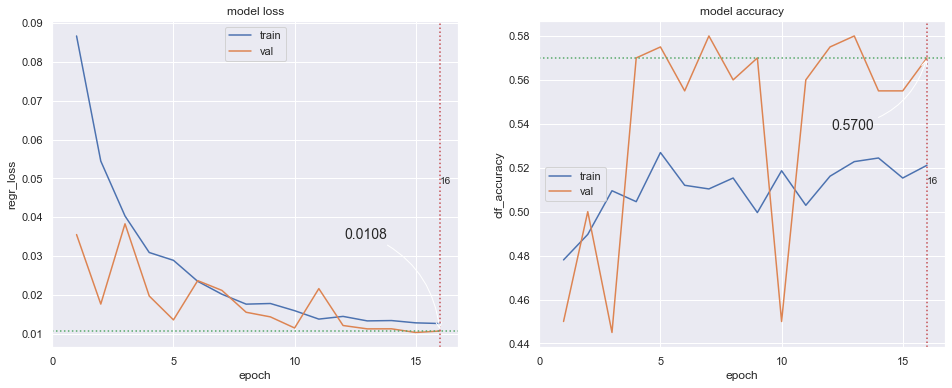

In [27]:
def plot_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    Utils.plot_train_history(ax[0], hist, 'model loss', 'regr_loss', 'val_regr_loss')
    Utils.plot_train_history(ax[1], hist, 'model accuracy', 'clf_accuracy', 'val_clf_accuracy')
    
plot_history(history.history);

## Прогноз

In [28]:
multivariate_lstm.load_weights('multivariate_lstm.hdf5')

In [29]:
predictions = multivariate_lstm.predict_generator(test_gen, verbose=1)

7/7 [==============================] - 0s 43ms/step


In [30]:
np.set_printoptions(precision=3, suppress=True)

np.column_stack(predictions)[-10:]

array([[-0.003,  0.502],
       [ 0.001,  0.494],
       [ 0.003,  0.492],
       [ 0.002,  0.489],
       [-0.001,  0.491],
       [ 0.003,  0.499],
       [ 0.001,  0.508],
       [ 0.004,  0.514],
       [ 0.003,  0.52 ],
       [ 0.005,  0.529]], dtype=float32)

### Прогноз задачи регрессии

In [31]:
def plot_predictions(market_data, pred_logret):
    fig = plt.figure(figsize=(19, 10))
    plt.title(f'{market_data.get_instrument()} daily log return')
    plt.xlabel('Date')
    plt.ylabel('Log return')
    x = market_data.get_timestamps()[-len(pred_logret):]
    plt.plot(x, market_data.get_c_logret()[-len(pred_logret):], label='Real')
    plt.plot(x, pred_logret, label='Predicted')
    plt.legend(loc='best')

*Не совсем понятный мне момент - почему модель довольно "консервативна" в прогнозах? Не выходит за коридор 1-2%, хотя в реальных данных разброс больше.*

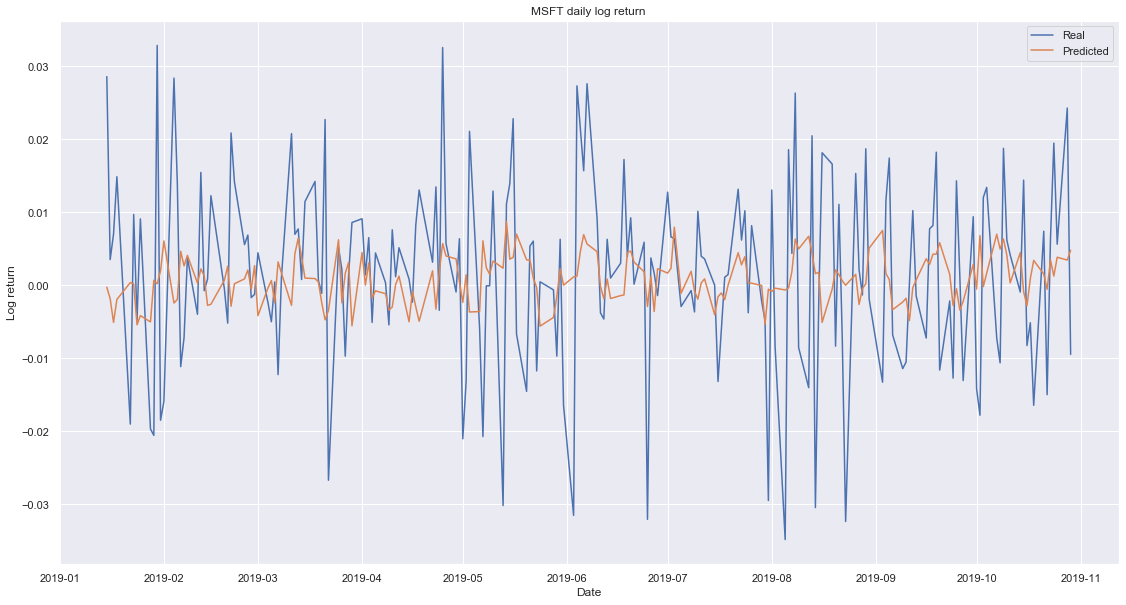

In [32]:
plot_predictions(msft, predictions[0])

### Прогноз задачи классификации

In [33]:
true_direction = msft_mwf.get_target_direction(msft_mwf.get_target()[-len(predictions[1]):])

predicted_direction = (0.5 < predictions[1]).astype(np.int)

In [34]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([ 84, 116], dtype=int64)),
 (array([0, 1]), array([ 39, 161], dtype=int64)))

In [35]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.44      0.20      0.28        84
           1       0.58      0.81      0.68       116

    accuracy                           0.56       200
   macro avg       0.51      0.51      0.48       200
weighted avg       0.52      0.56      0.51       200



In [36]:
confusion_matrix(true_direction, predicted_direction)

array([[17, 67],
       [22, 94]], dtype=int64)

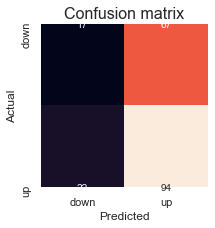

array([[17, 67],
       [22, 94]], dtype=int64)

In [37]:
def show_confusion_matrix(true, pred, labels):
    plt.figure(figsize=(3, 3))
    
    conf_matrix = confusion_matrix(true, pred)
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cbar=False)
    plt.title('Confusion matrix', fontsize=16)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return conf_matrix

show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

### Предварительный вывод по прогнозам

1.  Размер батча сильно влияет на скорость обучения.
2.  Инициализация весов в (`bias_initializer`) в слое **LSTM** оказалась очень важным параметром. Если туда, например, поставить `ones`, то классификация вообще в итоге обучается только на один класс. А вот `he` или `glorot` дают более приемлемый результат.
3.  Довольно быстро переобучается. По идее, можно вообще ограничиться парой эпох, особенно для задачи классификации. Дальнейшее обучение существенного прироста точности не даёт.
4.  Веса функций потерь при композиции в общий лосс тоже довольно важны. `binary_crossentropy` для классификации с какого-то момента почти не меняется. При этом `MAE` даёт числа немного другого порядка, поэтому веса надо подбирать аккуратно.
5.  Про какую-то высокую точность, конечно, говорить не приходится. Хотя предсказывает оба класса, причём движение вверх даже с точностью&nbsp;>&nbsp;50%
6. Вообще, обучение довольно нестабильно. Например, модель может при некоторых запусках на регрессии спрогнозировать только положительные доходности на весь период. Ещё, как я отметил, непонятно, почему диапазон значений регрессии уже, чем в реальных данных. Точность классификации, особенно по классу 0, тоже плавает от запуска к запуску.

## Открытые вопросы

Здесь коротко резюмирую открытые вопросы, которые появлялись по ходу исследования:

1.  Желательная глубина истории. Предположительно, зависит от уровня дискретизации данных. Для дневных цен, наверное, не имеет смысла смотреть очень далеко назад. Для высокочастотных рядов (минутные, либо даже отдельные тики), возможно, наоборот, имеет смысл увеличивать размер датасета.

2.  Стандартизация данных. Как правильно её проводить с учётом нестационарности временных рядов?

3.  Гиперпараметры модели. Стандартные проблемы: число нейронов в слое, инициализация весов, регуляризация.

4.  Функция потерь для задачи регрессии. По смыслу задачи нас волнует не только абсолютное отклонение, но и его знак. Имеет ли смысл пробовать нестандартные функции потерь?

5.  Почему-то абсолютные значения предсказанной доходности имеют меньший разброс, чем реальные данные. Хорошо бы  понять, что может быть причиной этого.

---

### References

**[1]** [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/ "How to Check if Time Series Data is Stationary with Python")

**[2]** [Прогнозирование временных рядов - YouTube](https://www.youtube.com/watch?v=u433nrxdf5k "Лекция 10 Прогнозирование временных рядов - YouTube")

**[3]** [Using stride tricks with NumPy](https://ipython-books.github.io/46-using-stride-tricks-with-numpy/ "IPython Cookbook - 4.6. Using stride tricks with NumPy")

**[4]** [Time series forecasting &nbsp;|&nbsp; TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series "Time series forecasting &nbsp;|&nbsp; TensorFlow Core")

**[5]** [Recurrent Neural Networks (RNN) with Keras &nbsp;|&nbsp; TensorFlow Core](https://www.tensorflow.org/guide/keras/rnn "Recurrent Neural Networks (RNN) with Keras &nbsp;|&nbsp; TensorFlow Core")

**[6]** [Neural networks for algorithmic trading. Multivariate time series](https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-2-1-multivariate-time-series-ab016ce70f57 "Neural networks for algorithmic trading. Multivariate time series")

**[7]** [Bayesian Methods for Hackers &nbsp;|&nbsp; Chapter5_LossFunctions](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb "CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers")

**[8]** [Understanding Input and Output shapes in LSTM | Keras](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e "Understanding Input and Output shapes in LSTM | Keras")

**[9]** [Difference Between Return Sequences and Return States for LSTMs in Keras](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/ "Difference Between Return Sequences and Return States for LSTMs in Keras")